# **Image Caption Generator** 

- In this project I will implement image caption generator that takes an input image and generate a caption that describes the image.
- I used the Flicker8K Dataset which you can find here [link](https://github.com/AmritK10/Image_Captioning)  
- First we will extract the features from the images using Xception pre-trained model and encode the captions using Keras tokenizer class to train the model.
- in testing we will feed the model with the feature of the test image and a starting word to generate the second word and this process will repeat recursively to generate the full description caption.     

# Agenda for the notebook:
--------------------------------
1. Importing Required Libraries
2. Retrieving the data (Images and Desctiption Captions)
3. Defining the Pathes variables
4. Preparing the images
 * 4.1. Defining the model
 * 4.2. Extracting the features from the images

5. Preparing the Description Captions text
  * 5.1. Loading the captions of all images
  * 5.2. Creating the dictionary of images-captions pairs
  * 5.3. Cleaning the descriptions

6. Preparing the training data (features and description captions)
7. Tokenization
  * 7.1. Creating the training corpus
  * 7.2. Creaing the tokenizer object to map each word to number

8. Preparing the validation data: (features and description)
9. Creating the data generator
10. Defining the model
11. Testing the model on the testing images

## 1. Importing Required Libraries

In [ ]:
import numpy as np
import os
import cv2
import string
import random
from pickle import dump, load
import tensorflow
import matplotlib.pyplot as plt
from tensorflow.keras.applications import Xception
from keras.applications.xception import preprocess_input
from keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout
from keras.layers.merge import add
from google.colab.patches import cv2_imshow

## 2. Retrieving the data (Images and Desctiption Captions)

In [ ]:
%%capture
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip /content/Flickr8k_Dataset.zip
!unzip /content/Flickr8k_text.zip

## 3. Defining the Pathes variables

In [ ]:
images_path = '/content/Flicker8k_Dataset'
images_captions_path = '/content/Flickr8k.token.txt'
training_path = '/content/Flickr_8k.trainImages.txt'
validation_path = '/content/Flickr_8k.devImages.txt'
testing_path = '/content/Flickr_8k.testImages.txt'

## 4. Preparing the images

### 4.1. Defining the CNN Model
##### overview of the Xception model
- Xception is a deep convolutional neural network architecture that involves Depthwise Separable Convolutions. Xception is also known as “extreme” version of an Inception module.
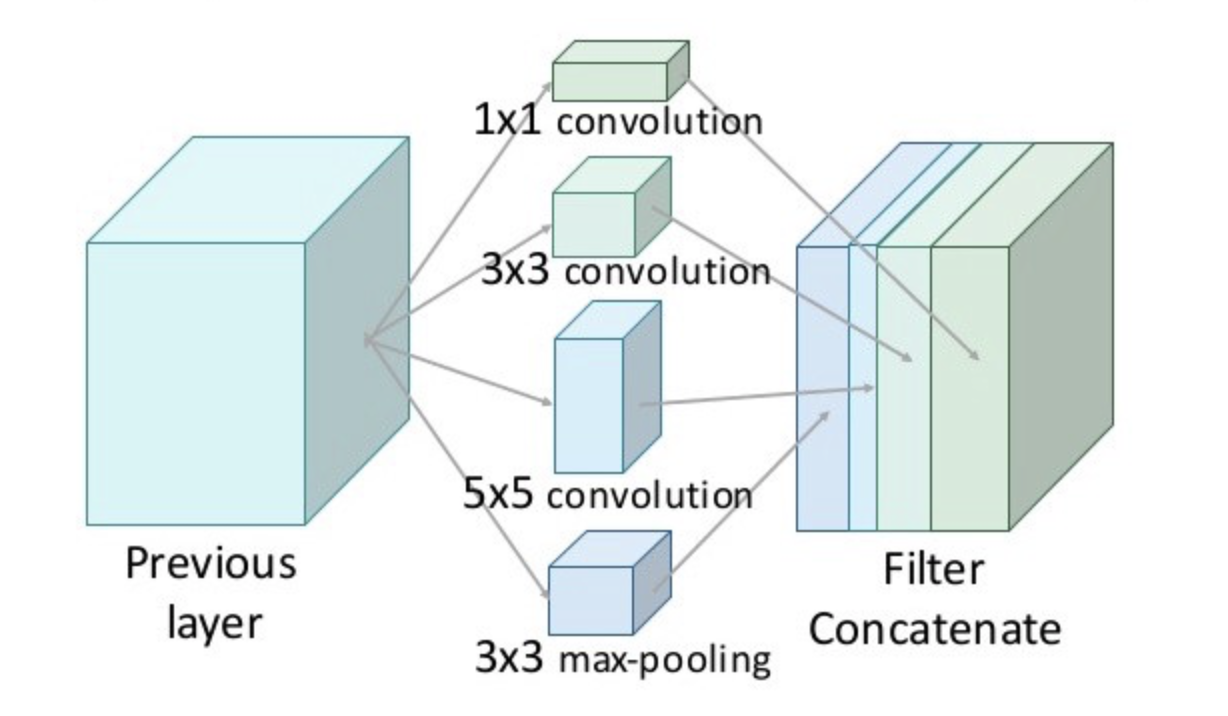

In [ ]:
%%capture
# extracting all the model except the last 1000 neuron layer and the last layer will be 2048 vactor length
CNN_Model = model = Xception(include_top=False, pooling="avg")

### 4.2. Extracting the features from the images

In [ ]:
# features = {}
# for image in os.listdir(images_path):
#   img = load_img(images_path+"/"+image, target_size=(224, 224))
#   img = img_to_array(img)
#   img = preprocess_input(img)
#   img = np.expand_dims(img, axis=0)
#   feature = CNN_Model.predict(img)
#   features[image] = feature

# saving the features for later use
# dump(features, open("XCeptionfeatures.p","wb"))

In [ ]:
# loading the features instead of running the above cell each ime
%%capture
! gdown --id 1wCqLqO8ZY5jEjvjU1yxNUcwpN7QRyBfg
features = load(open("XCeptionfeatures.p","rb"))

In [ ]:
print("Number of Features: ",len(features))

Number of Features:  8091


## 5. Preparing the Description Captions text

In [ ]:
# here we define a function to read text files
def load_text(file_path):
  file = open(file_path, 'r')
  text = file.read()
  file.close()
  return text

### 5.1. Loading the captions of all images

In [ ]:
images_captions  = load_text(images_captions_path).split('\n')[:-1]

### 5.2. Creating the dictionary of images-captions pairs

In [ ]:
# creating a dictionary with a key of the image name and value is a list which stores the captions with that image.
all_descriptions ={}
# looping over the lines in the image_captions text file
for caption in images_captions:
    # splitting the line by tab to get the image name as the first element and the caption as the second element.
    caption = caption.split('\t')
    caption[0] = caption[0][:-2]
    caption[1] = caption[1][:-2]
    # assigning the captions with its specified image name.
    if caption[0] not in all_descriptions:
      all_descriptions[caption[0]] = [caption[1]]
    else:
      all_descriptions[caption[0]].append(caption[1])

# here we remove the key-value paires from the dictionary as it isn't included in the images
del all_descriptions["2258277193_586949ec62.jpg.1"]

### 5.3. Cleaning the descriptions

In [ ]:
table = str.maketrans('','',string.punctuation)
# looping over the image-captions pairs
for img,caps in all_descriptions.items():
  # looping over the captions of the image
  for i,img_caption in enumerate(caps):
    img_caption.replace("-"," ")
    # splitting the capion into words
    descp = img_caption.split()
    # convert the caption to lower case
    descp = [wrd.lower() for wrd in descp]
    descp = [wrd.translate(table) for wrd in descp]
    # removing any word with length equals 1 (e.g. 'a')
    descp = [wrd for wrd in descp if(len(wrd)>1)]
    # removing words that contain any numbers
    descp = [wrd for wrd in descp if(wrd.isalpha())]
    # converting back to caption
    img_caption = ' '.join(descp)
    all_descriptions[img][i]= img_caption

In [ ]:
print("Number of images: ",len(all_descriptions))

Number of images:  8091


In [ ]:
# sorting the features and descriptions dictionary to ensure that every feature is matched with its image-caption paire in the descriptions dictionary
features = {key:features[key] for key in sorted(features.keys())}
all_descriptions = {key:all_descriptions[key] for key in sorted(all_descriptions.keys())}

## 6. Preparing the training data (features and description captions)

In [ ]:
# defining a function to extract specific descriptions (training or validation) from the desctiption dictionary 
# that conains all the data
def extract_descriptions(images):
  descriptions = {}
  # looping over the key-value paires of the description dictionary
  for image,captions in all_descriptions.items():
    # checking if the image in the (training or validation images name)
    if image in images:
      if image not in descriptions:
        descriptions[image] = []
        for caption in captions:
          # adding 'startseq' and 'endseq' tokens to each caption in the captions of the training or validation captions 
          # to teach the model the start and the end of each caption
          caption = 'startseq ' + caption + ' endseq'
          descriptions[image].append(caption)
  return descriptions

In [ ]:
# loading the train images names
train_images = load_text(training_path).split("\n")[:-1]
# extracting the training descriptions
train_descriptions = extract_descriptions(train_images)
print("Number of training images: ",len(train_descriptions))
# extracting the training features
train_features = {photo:features[photo] for photo in train_images}
print("Number of training features: ",len(train_features))

Number of training images:  6000
Number of training features:  6000


In [ ]:
# sorting the features and descriptions dictionary to ensure that every feature is matched with its image-caption paire in the descriptions dictionary
train_descriptions = {key:train_descriptions[key] for key in sorted(train_descriptions.keys())}
train_features = {key:train_features[key] for key in sorted(train_features.keys())}

## 7. Tokenization

### 7.1. Creating the training corpus

In [ ]:
train_captions_list = []
for key in train_descriptions.keys():
  for desc in train_descriptions[key]:
    train_captions_list.append(desc)

### 7.2. Creaing the tokenizer object to map each word to number

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_captions_list)
dump(tokenizer, open('tokenizer.p', 'wb'))

In [ ]:
# the number of the words in a corpus
vocab_size = len(tokenizer.word_index) + 1
print("Number of words in the corpus: ",vocab_size)
# the maximam length of a sentence in the training captions
max_length  = max(len(d.split()) for d in train_captions_list)
print("The maximum length of caption in the training captions: ",max_length)

Number of words in the corpus:  8097
The maximum length of caption in the training captions:  34


In [ ]:
# loading the tokenizer instead of loading the training dataset again to run tokenizer on it
%%capture
!gdown --id 1hJIG3NY-44gjsn7NDn3s3VSLsG94XR2P
tokenizer = load(open('tokenizer.p', 'rb'))

## 8. Preparing the validation data: (features and description)

In [ ]:
# loading the validation images names
validation_images = load_text(validation_path).split("\n")[:-1]
# extracting the validation descriptions
validation_descriptions = extract_descriptions(validation_images)
print("Number of validation images: ",len(validation_descriptions))
# extracting the validation features
validation_features = {photo:features[photo] for photo in validation_images}
print("Number of validation features: ",len(validation_features))

Number of validation images:  1000
Number of validation features:  1000


In [ ]:
# sorting the features and descriptions dictionary to ensure that every feature is matched with its image-caption paire in the descriptions dictionary
validation_descriptions = {key:validation_descriptions[key] for key in sorted(validation_descriptions.keys())}
validation_features = {key:validation_features[key] for key in sorted(validation_features.keys())}

## 9. Creating the data generator

In [ ]:
#data generator, used by model.fit()
def data_generator(descriptions, features, tokenizer, max_length):
  while 1:
    for key, description_list in descriptions.items():
      #retrieve image features
      feature = features[key][0]
      inp_image, inp_seq, op_word = create_sequences(tokenizer, max_length, description_list, feature)
      yield [[inp_image, inp_seq], op_word]

def create_sequences(tokenizer, max_length, desc_list, feature):
    x1, x2, y = list(), list(), list()
    # move through each description for the image
    for desc in desc_list:
    # encode the sequence
      seq = tokenizer.texts_to_sequences([desc])[0]
      # divide one sequence into various X,y pairs
      for i in range(1, len(seq)):
        # divide into input and output pair
        in_seq, out_seq = seq[:i], seq[i]
        # pad input sequence
        in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
        # encode output sequence
        out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
        # appending the feature
        x1.append(feature)
        # appending the input sequence
        x2.append(in_seq)
        # appending the output sequence
        y.append(out_seq)
    return np.array(x1), np.array(x2), np.array(y)
#To check the shape of the input and output for your model
[x1,x2],y = next(data_generator(train_descriptions, features, tokenizer, max_length))
x1.shape, x2.shape, y.shape
#((47, 2048), (47, 34), (47, 8097))

((47, 2048), (47, 34), (47, 8097))

## 10. Defining the model

- The final model that we will train will accept two inputs the first one represents the images features (output of the Xception model) and the second input is the sequence of words. the output of the model will be one hot encoded vector with length of number vocab word we got from the tokenizer. 

In [ ]:
# features from the CNN model compressed from 2048 to 256 nodes
inputs1 = Input(shape=(2048,))
feature_model = Dropout(0.5)(inputs1)
feature_model = Dense(256, activation='relu')(feature_model)
# LSTM sequence model
inputs2 = Input(shape=(max_length,))
sequence_model = Embedding(vocab_size, 256,input_length = max_length, mask_zero=True)(inputs2)
sequence_model = Dropout(0.5)(sequence_model)
sequence_model = LSTM(256)(sequence_model)
# Merging both models
decoder = add([feature_model, sequence_model])
decoder = Dense(256, activation='relu')(decoder)
outputs = Dense(vocab_size, activation='softmax')(decoder)
# merge it [image, seq] [word]
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 34, 256)      2072832     ['input_8[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 2048)         0           ['input_7[0][0]']                
                                                                                            

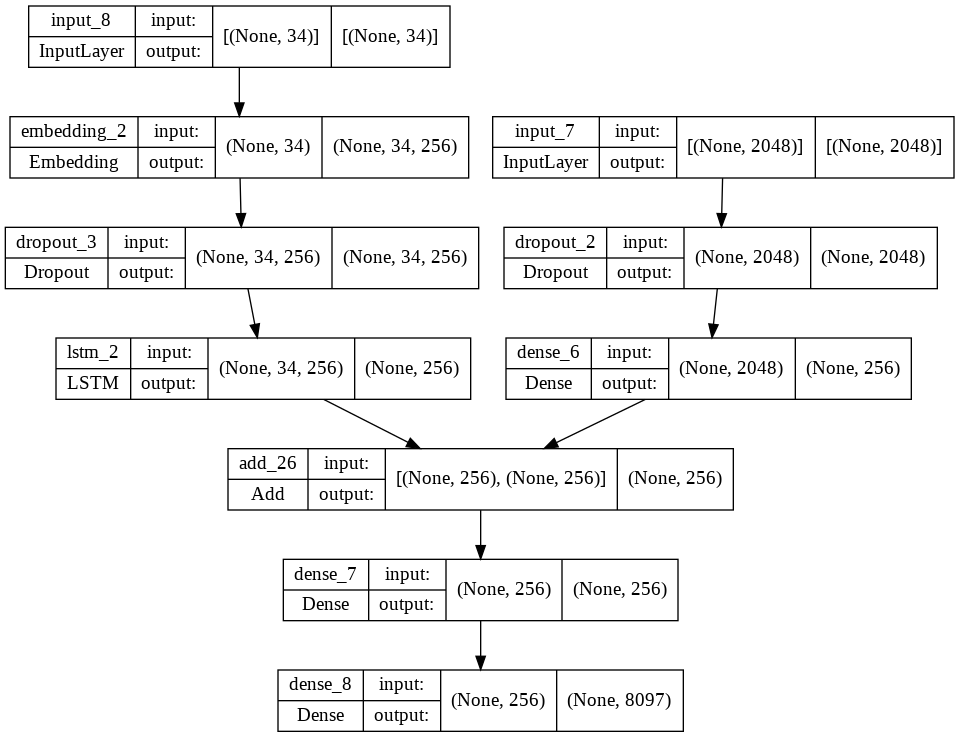

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
# training the model
train_steps = len(train_descriptions)
val_steps = len(validation_descriptions)
# Early stopping callback which stop the training if the training loss doesn't change over 0.05 for three consecuetive times
callback = tensorflow.keras.callbacks.EarlyStopping(monitor='loss',min_delta= 0.05,patience=3,mode = 'min')

train_generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
validation_generator = data_generator(validation_descriptions, validation_features, tokenizer, max_length)
history = model.fit(train_generator, epochs=5, steps_per_epoch= train_steps,verbose = 1)

Epoch 1/5
6000/6000 [==============================] - 820s 135ms/step - loss: 4.7318 - val_loss: 4.1924
Epoch 2/5
6000/6000 [==============================] - 809s 135ms/step - loss: 3.9566 - val_loss: 4.0364
Epoch 3/5
6000/6000 [==============================] - 823s 137ms/step - loss: 3.7048 - val_loss: 4.0043
Epoch 4/5
6000/6000 [==============================] - 814s 136ms/step - loss: 3.5571 - val_loss: 4.0378
Epoch 5/5
6000/6000 [==============================] - 806s 134ms/step - loss: 3.4549 - val_loss: 4.0794


In [ ]:
# saving the model
model_path = "XCeption_Model.model"
model.save(model_path, save_format="h5")

In [ ]:
# loading the model if you reopen the notebook instead of training the model again 
%%capture
! gdown --id 1ibcSCYBNWi9t98nEedMmFPIMfWjhogtJ
model = load_model('/content/XCeption_Model.model')

## 11. Testing the model on the testing images

In [ ]:
# defining a function to map the index to word in the tokenizer word_index dictionary
def word_for_id(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == integer:
      return word
  return None
  
# defining a function to preprocess the image and extract its feature to fed it to the model
def extract_image_feature(image_path):
  img = load_img(image_path, target_size=(299, 299))
  img = img_to_array(img)
  img = preprocess_input(img)
  img = np.expand_dims(img, axis=0)
  feature = CNN_Model.predict(img)
  return feature

# generating the description of an input image
def generate_description(image_path,max_length):
  feature = extract_image_feature(image_path)
  generated_text = 'startseq'
  for i in range(max_length):
    sequence = tokenizer.texts_to_sequences([generated_text])[0]
    sequence = pad_sequences([sequence], maxlen=max_length)
    pred = model.predict([feature,sequence], verbose=0)
    pred = np.argmax(pred)
    word = word_for_id(pred, tokenizer)
    if word is None:
      break
    generated_text += ' ' + word
    if word == 'endseq':
      break
  generated_text = ' '.join(generated_text.split()[1:-1])
  return generated_text

In [ ]:
# loading the testing images names
testing_images = load_text(testing_path).split("\n")[:-1]
# extracting the validation descriptions
testing_descriptions = extract_descriptions(testing_images)
print("Number of testing images: ",len(testing_descriptions))
# extracting the validation features
testing_features = {photo:features[photo] for photo in testing_images}
print("Number of testing features: ",len(testing_features))

Number of testing images:  1000
Number of testing features:  1000


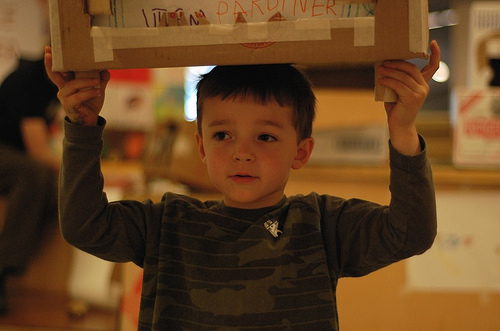

-----------------------------------------
Predicted Sequence :   young boy is playing with toy
------------------------------------
Actual_captions:
boy holds picture over his head
boy in long sleeve shirt is holding box above his head
boy is inside holding something on top of his head
little boy holds decorated cardboard box on his head
young boy with samll cardboard box atop his head


In [ ]:
# choosing random image from the testing data
image_name = random.choice(testing_images)
# loading the test image
image_path = images_path +"/"+ image_name
image = cv2.imread(image_path)
cv2_imshow(image)
print("-----------------------------------------")
generated_sequence = generate_description(image_path,max_length)
print("Predicted Sequence :  ",generated_sequence)
print("------------------------------------")
print("Actual_captions:")
for d in testing_descriptions[image_name]: 
   print(' '.join(d.split()[1:-1]))